# Advanced Feature Engineering in Keras 

**Learning Objectives**

1. Process temporal feature columns in Keras
2. Use Lambda layers to perform feature engineering on geolocation features 
3. Create bucketized and crossed feature columns
 

## Introduction 

In this notebook, we use Keras to build a taxifare price prediction model and utilize feature engineering to improve the fare amount prediction for NYC taxi cab rides. 

Each learning objective will correspond to a __#TODO__ in this student lab notebook 

## Set up environment variables and load necessary libraries 
We will start by importing the necessary libraries for this lab.

In [48]:
import datetime
import logging
import math
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import models

# set TF error log verbosity
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(tf.version.VERSION)

2.1.0


Next, we initialize model parameters

In [15]:
# a lot of these variables don't make sense yet
DATADIR = '../data'  # do we use this
NBUCKETS = 10
TRAIN_BATCH_SIZE = 32 

NUM_TRAIN_EXAMPLES = 59126 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 17000

## Load taxifare dataset

The Taxi Fare dataset for this lab is 106,545 rows and has been pre-processed and split for use in this lab.  Note that the dataset is same as used in the Big Query feature engineering labs.  The fare_amount is the target, the continuous value we’ll train a model to predict.  

First, let's download the  .csv data by copying the data from a cloud storage bucket.

In [21]:
!mkdir ../data

In [22]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/*.csv ../data

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...               
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...               
/ [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


Let's check that the files were copied correctly and look like we expect them to.

In [23]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 1113292 Feb 20 13:24 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 3551735 Feb 20 13:24 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter  888648 Feb 20 13:24 ../data/taxi-valid.csv


In [24]:
!head ../data/*.csv

==> ../data/taxi-test.csv <==
fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
7.7,4,-73.987998,40.764815000000006,-73.980602,40.744547999999995,15,3
11.5,1,-73.99378,40.75575,-73.97917,40.72579,22,4
7.3,1,-73.97940899999999,40.781647,-73.955749,40.772529999999996,12,6
8.5,1,-73.98869300000001,40.727032,-73.998685,40.73437,21,3
6.5,1,-73.947773,40.790307,-73.95327900000001,40.778389000000004,23,2
4.9,2,-74.000364,40.728729,-74.00884599999999,40.725924,11,1
3.7,3,-73.98424,40.755512,-73.990392,40.752039,7,3
4.9,4,-73.989798,40.762527,-73.989848,40.773913,16,2
11.7,2,-73.990573,40.728769,-73.938254,40.720831,8,6

==> ../data/taxi-train.csv <==
fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
8.1,1,-73.973731,40.791909999999994,-73.962737,40.767317999999996,14,4
4.5,2,-73.98649499999999,40.739278000000006,-73.986083,40.730933,10,6
2.9,1,-73.95604300000001,4

## Create an input pipeline 

Typically, you will use a two step proces to build the pipeline. Step one is to define the columns of data; i.e., which column we're predicting for, and the default values.  Step 2 is to define two functions - a function to define the features and label you want to use and a function to load the training data.  Also, note that pickup_datetime is a string and we will need to handle this in our feature engineered model.  


In [25]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key',
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

In [26]:
# A function to define features and labesl
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label

# A utility method to create a tf.data dataset from a Pandas Dataframe
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = tf.data.experimental.make_csv_dataset(pattern,
                                                  batch_size,
                                                  CSV_COLUMNS,
                                                  DEFAULTS)
  dataset = dataset.map(features_and_labels)  # features, label
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(1000).repeat()
    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
  return dataset

## Create a Baseline DNN Model in Keras

Now let's build the Deep Neural Network (DNN) model in Keras using the functional API. Unlike the sequential API, we will need to specify the input and hidden layers.  Note that we are creating a linear regression baseline model with no feature engineering. Recall that a baseline model is a solution to a problem without applying any machine learning techniques.

In [33]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():  # Build the DNN model
    NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude',
                    'passenger_count']

# input layer
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

# feature_columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

# Constructor for DenseFeatures takes a list of numeric columns
# The Functional API in Keras requires you specify: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

# two hidden layers of [32, 8] just in like the BQML DNN
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

# final output is a linear activation because this is regression
    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs, output)

# compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model


model = build_dnn_model()

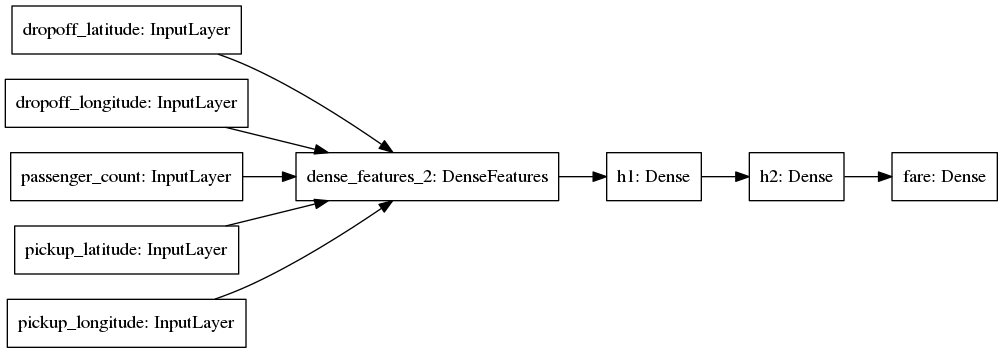

In [34]:
# Here is our baseline DNN architecture
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).  Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

Note:  Ensure that a directory called "data" exists and includes the taxi-train, taxi-test, and taxi-valid .csv files.

In [35]:
trainds = load_dataset('data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 1847 steps, validate for 17 steps
Epoch 1/5
1847/1847 [==============================] - 8s 4ms/step - loss: 104.5295 - rmse: 9.5726 - mse: 104.5294 - val_loss: 101.9536 - val_rmse: 10.0763 - val_mse: 101.9536
Epoch 2/5
1847/1847 [==============================] - 7s 4ms/step - loss: 103.3924 - rmse: 9.5681 - mse: 103.3924 - val_loss: 99.3948 - val_rmse: 9.9503 - val_mse: 99.3948
Epoch 3/5
1847/1847 [==============================] - 6s 3ms/step - loss: 104.0070 - rmse: 9.6152 - mse: 104.0070 - val_loss: 100.3085 - val_rmse: 9.9881 - val_mse: 100.3085
Epoch 4/5
1847/1847 [==============================] - 6s 3ms/step - loss: 102.9360 - rmse: 9.5806 - mse: 102.9360 - val_loss: 99.5851 - val_rmse: 9.9687 - val_mse: 99.5851
Epoch 5/5
1847/1847 [==============================] - 6s 3ms/step - loss: 102.8609 - rmse: 9.5505 - mse: 102.8610 - val_loss: 99.3355 - val_rmse: 9.9497 - val_mse: 99.3355


### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

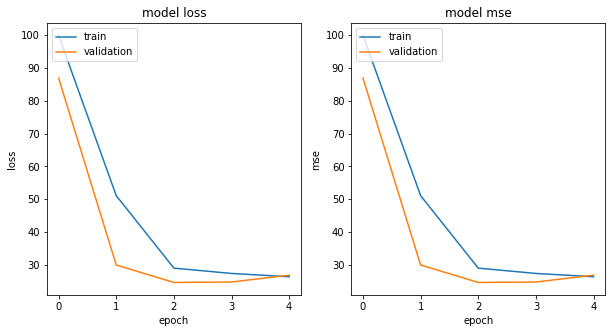

In [60]:
# this is done twice. Should we make it a separate function?
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

### Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.  Next we note the fare price at this geolocation and pickup_datetime.

In [38]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

array([[12.567629]], dtype=float32)

## Improve Model Performance Using Feature Engineering 

We now improve our model's performance by creating the following feature engineering types:  Temporal, Categorical, and Geolocation. 

### Temporal Feature Columns

We incorporate the temporal feature pickup_datetime.  As noted earlier, pickup_datetime is a string and we will need to handle this within the model.  First, you will include the pickup_datetime as a feature and then you will need to modify the model to handle our string feature.

In [51]:
# TODO 1a
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8')
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

# TODO 1b
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

# TODO 1c
@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in)

### Geolocation/Coordinate Feature Columns

The pick-up/drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled. As such, we need to teach the model the Euclidean distance between the pick-up and drop-off points.

Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates. In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

#### Computing Euclidean distance
The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

In [52]:
# TODO 2
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

#### Scaling latitude and longitude

It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling (also called normalization) on the geolocation fetures.  Later in our model, you will see that these values are shifted and rescaled so that they end up ranging from 0 to 1.

First, we create a function named 'scale_longitude' where we pass in all the longitudinal values and add 78 to each value.  Note that our scaling longitude ranges from -70 to -78. Thus, the value 78 is the maximum longitudinal value.  The delta or difference between -70 and -78 is 8.  We add 78 to each longitidunal value and then divide by 8 to return a scaled value.

In [71]:
def scale_longitude(lon_column):
    return (lon_column + 78)/8.

Next, we create a function named 'scale_latitude' where we pass in all the latitudinal values and subtract 37 from each value.  Note that our scaling longitude ranges from -37 to -45. Thus, the value 37 is the minimal latitudinal value.  The delta or difference between -37 and -45 is 8.  We subtract 37 from each latitudinal value and then divide by 8 to return a scaled value.

In [72]:
    def scale_latitude(lat_column):
    return (lat_column - 37)/8.

### Putting it all together
We now create two new "geo" function for our model.  We create a function called "euclidean" to initialize our geolocation parameters.  We then create a function called transform.   The transform function passes our numerical and string columns features as inputs to the model, scales geolocation features, then creates the Euclian distance as a transformed variable with the geolocation features. Lastly, we bucketize the latitude and longitude features.

In [67]:
def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("Inputs before features transformation: {}".format(inputs.keys()))

    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']

    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name="scale_{}".format(lon_col))(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name='scale_{}'.format(lat_col))(inputs[lat_col])

    # TODO 2
    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    # TODO 3
    # create bucketized features
    latbuckets = np.linspace(0, 1, NBUCKETS).tolist()
    lonbuckets = np.linspace(0, 1, NBUCKETS).tolist()
    b_plat = fc.bucketized_column(
        feature_columns['pickup_latitude'], latbuckets)
    b_dlat = fc.bucketized_column(
        feature_columns['dropoff_latitude'], latbuckets)
    b_plon = fc.bucketized_column(
        feature_columns['pickup_longitude'], lonbuckets)
    b_dlon = fc.bucketized_column(
        feature_columns['dropoff_longitude'], lonbuckets)
    
    # TODO 3
    # create crossed columns
    ploc = fc.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = fc.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = fc.crossed_column([ploc, dloc], nbuckets ** 4)
    
    # create embedding columns
    feature_columns['pickup_and_dropoff'] = fc.embedding_column(pd_pair, 100)

    print("Transformed features: {}".format(transformed.keys()))
    print("Feature columns: {}".format(feature_columns.keys()))
    return transformed, feature_columns

In [68]:
# DNN MODEL
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }
    inputs.update({
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='string')
        for colname in STRING_COLS
    })

    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs, output)

    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()

Here is our DNN architecture so far:

['pickup_datetime']
{'pickup_longitude', 'dropoff_longitude', 'passenger_count', 'dropoff_latitude', 'pickup_latitude'}
Inputs before features transformation: dict_keys(['pickup_longitude', 'dropoff_longitude', 'pickup_datetime', 'passenger_count', 'pickup_latitude', 'dropoff_latitude'])
Transformed features: dict_keys(['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'euclidean', 'passenger_count', 'dropoff_latitude'])
Feature columns: dict_keys(['pickup_longitude', 'dropoff_longitude', 'pickup_and_dropoff', 'passenger_count', 'euclidean', 'pickup_latitude', 'dropoff_latitude'])


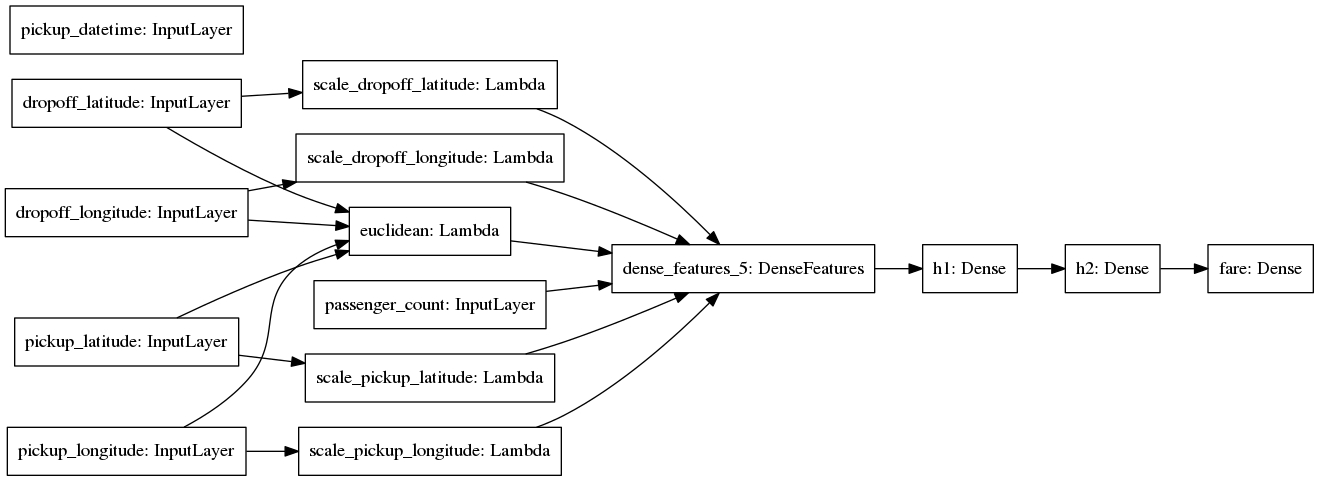

In [69]:
# Here is our baseline DNN architecture
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [70]:
trainds = load_dataset('../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 1847 steps, validate for 17 steps
Epoch 1/5
1847/1847 [==============================] - 15s 8ms/step - loss: 101.3848 - rmse: 9.4499 - mse: 101.3848 - val_loss: 95.7196 - val_rmse: 9.7668 - val_mse: 95.7196
Epoch 2/5
1847/1847 [==============================] - 13s 7ms/step - loss: 72.7391 - rmse: 7.8307 - mse: 72.7391 - val_loss: 36.6313 - val_rmse: 5.9713 - val_mse: 36.6313
Epoch 3/5
1847/1847 [==============================] - 13s 7ms/step - loss: 29.9263 - rmse: 4.5464 - mse: 29.9263 - val_loss: 27.7428 - val_rmse: 5.1874 - val_mse: 27.7428
Epoch 4/5
1847/1847 [==============================] - 14s 7ms/step - loss: 28.2835 - rmse: 4.4025 - mse: 28.2835 - val_loss: 26.5821 - val_rmse: 5.0835 - val_mse: 26.5821
Epoch 5/5
1847/1847 [==============================] - 13s 7ms/step - loss: 27.8546 - rmse: 4.3437 - mse: 27.8546 - val_loss: 25.6813 - val_rmse: 5.0149 - val_mse: 25.6813


As before, let's visualize the DNN model layers. 

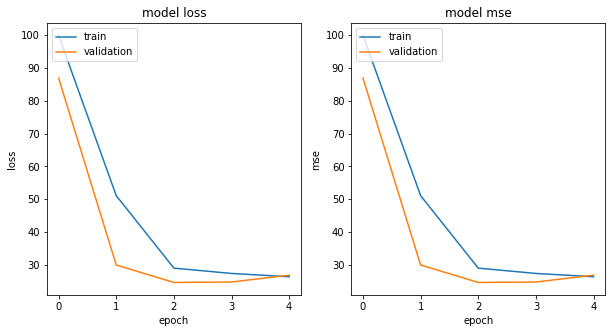

In [59]:
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

Next we note the fare price at this geolocation and pickup_datetime and compare it to the base model.


In [132]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

array([[7.0454063]], dtype=float32)

Below we summarize our training results comparing our baseline model with our model with engineered features. 

| Model              | Taxi Fare | Description                               |
|--------------------|-----------|-------------------------------------------|
| Baseline           | 11.00     | Baseline model - no feature engineering |
| Feature Engineered | 7.040      | Feature Engineered Model                |

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.